In [288]:
# !kaggle datasets download uciml/red-wine-quality-cortez-et-al-2009 --unzip -f winequality-red.csv

In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [290]:
data = pd.read_csv("winequality-red.csv")
data["quality"] = (
    data["quality"]
    .astype(object)
    .map({3: "low", 4: "low", 5: "medium", 6: "medium", 7: "high", 8: "high"})
)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,medium
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,medium
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,medium
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,medium
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,medium


Basic dataset information:

In [291]:
print(f"Number of samples: {len(data)}")
print(f"Number of features: {len(data.columns)-1}")

Number of samples: 1599
Number of features: 11


Missing values:

In [292]:
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


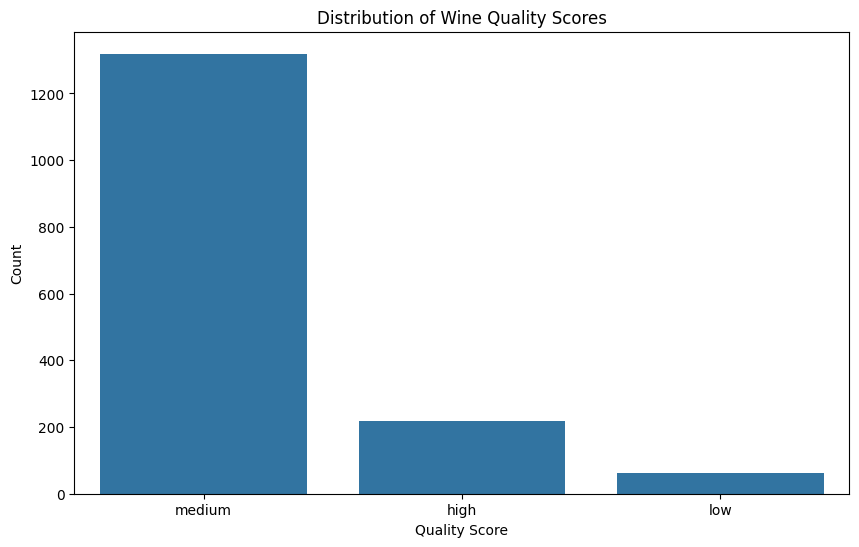


Quality score distribution:
quality
high       217
low         63
medium    1319
Name: count, dtype: int64


In [293]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x="quality")
plt.title("Distribution of Wine Quality Scores")
plt.xlabel("Quality Score")
plt.ylabel("Count")
plt.show()

print("\nQuality score distribution:")
print(data["quality"].value_counts().sort_index())

In [294]:
data.columns.tolist()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

<Axes: xlabel='alcohol', ylabel='free sulfur dioxide'>

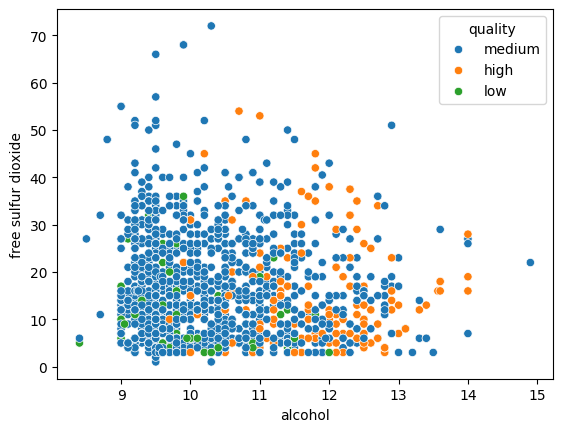

In [295]:
sns.scatterplot(data=data, x="alcohol", y="free sulfur dioxide", hue="quality")

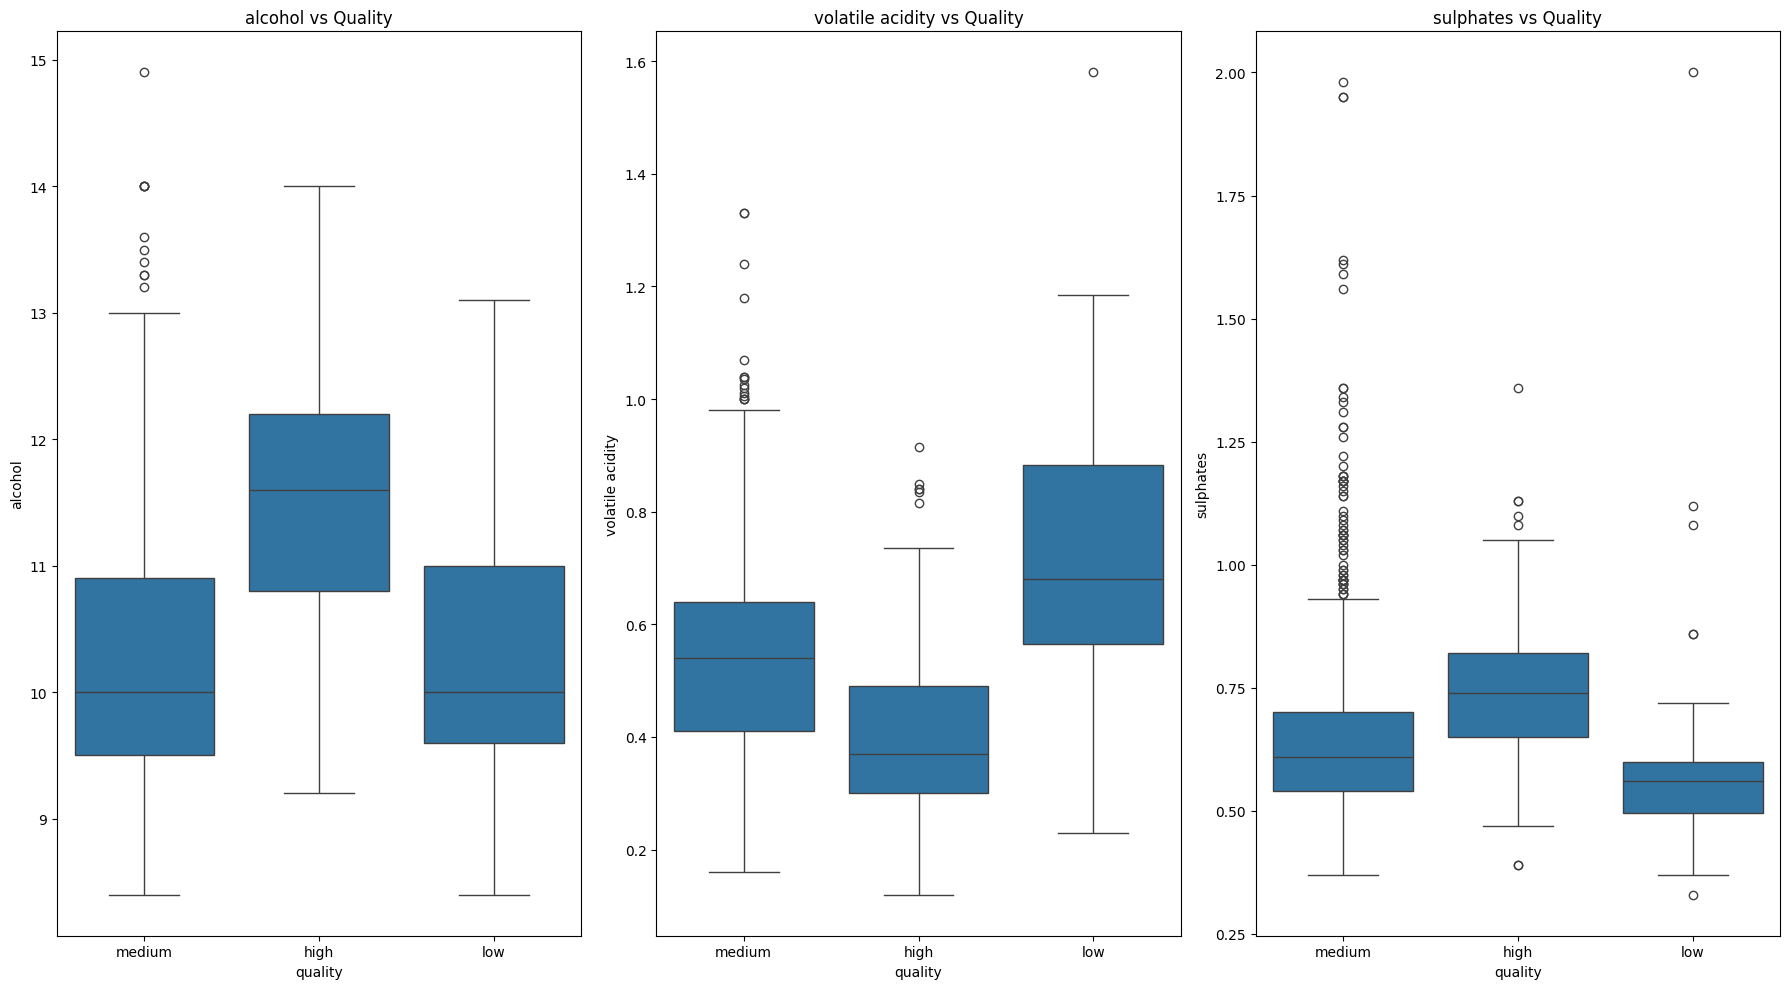

In [296]:
top_features = abs(quality_correlations[1:]).sort_values(ascending=False)[:3].index

fig, axes = plt.subplots(1, 3, figsize=(18, 10))
for i, feature in enumerate(top_features):
    sns.boxplot(data=data, x="quality", y=feature, ax=axes[i])
    axes[i].set_title(f"{feature} vs Quality")
plt.tight_layout()
plt.show()

Higher quality wines have higher alcohol content, lower volatile acidity and slightly higher density

possible significant interactions.

Summary statistics for each quality level:

In [297]:
quality_stats = data.groupby("quality").agg(["mean", "std"]).round(2)
quality_stats

fixed acidity       volatile acidity       citric acid        \
                 mean   std             mean   std        mean   std   
quality                                                                
high             8.85  2.00             0.41  0.14        0.38  0.19   
low              7.87  1.65             0.72  0.25        0.17  0.21   
medium           8.25  1.68             0.54  0.17        0.26  0.19   

        residual sugar       chlorides        ... total sulfur dioxide         \
                  mean   std      mean   std  ...                 mean    std   
quality                                       ...                               
high              2.71  1.36      0.08  0.03  ...                34.89  32.57   
low               2.68  1.72      0.10  0.08  ...                34.44  26.40   
medium            2.50  1.40      0.09  0.05  ...                48.95  32.71   

        density         pH       sulphates       alcohol        
           mean  std  mean   std      mean   std    mean   std  
quality                                                         
high        1.0  0.0  3.29  0.15      0.74  0.13   11.52  1.00  
low         1.0  0.0  3.38  0.18      0.59  0.22   10.22  0.92  
medium      1.0  0.0  3.31  0.15      0.65  0.17   10.25  0.97  

[3 rows x 22 columns]

In [298]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import (
    make_scorer,
    confusion_matrix,
    classification_report,
    balanced_accuracy_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    silhouette_score,
)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
import mlflow
import os

In [299]:
from dotenv import load_dotenv

load_dotenv()
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("wine-quality-prediction")

<Experiment: artifact_location='s3://mlflow-wine-quality-experiments/1', creation_time=1733152256225, experiment_id='1', last_update_time=1733152256225, lifecycle_stage='active', name='wine-quality-prediction', tags={}>

In [300]:
X = data.drop("quality", axis=1)
y = data["quality"].astype(object)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.4, random_state=293, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=293
)  # 60/20/20 split

clustering feature engineering

In [301]:
with mlflow.start_run():
    mlflow.sklearn.autolog()
    preprocessor = ColumnTransformer(
        [
            ("scaler", StandardScaler(), X_train.columns),
        ]
    )

    pipeline = ImbPipeline(
        [
            ("preprocessor", preprocessor),
            ("smote", SMOTE(random_state=0)),
            (
                "rfc",
                RandomForestClassifier(
                    random_state=0,
                    n_jobs=-1,
                    class_weight="balanced",  # warm_start=True
                ),
            ),
        ]
    )

    param_grid = {
        "rfc__n_estimators": np.arange(10, 1000, 10),
        "rfc__max_depth": np.arange(1, 10),
        "rfc__criterion": ["gini", "entropy"],
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=293)

    scoring = {
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "accuracy": make_scorer(accuracy_score),
        "precision": make_scorer(precision_score, average="weighted"),
        "recall": make_scorer(recall_score, average="weighted"),
        "f1": make_scorer(f1_score, average="weighted"),
    }

    grid_search = RandomizedSearchCV(
        pipeline,
        param_grid,
        cv=kf,
        scoring=scoring,
        n_jobs=-1,
        refit="balanced_accuracy",
        n_iter=100,
    )

    grid_search.fit(X_train, y_train)

    validation_predictions = grid_search.predict(X_val)

    cv = grid_search.cv_results_

    mlflow.log_dict(cv, "cv_results.json")

    mlflow.log_metrics(
        {
            "balanced_accuracy": balanced_accuracy_score(
                y_val,
                validation_predictions,
            ),
            "accuracy": accuracy_score(y_val, validation_predictions),
            "precision": precision_score(
                y_val, validation_predictions, average="weighted"
            ),
            "recall": recall_score(y_val, validation_predictions, average="weighted"),
            "f1": f1_score(y_val, validation_predictions, average="weighted"),
        }
    )

    # mlflow.log_params(grid_search.get_params())

    # mlflow.xgboost.log_model(grid_search, "model")

2024/12/04 11:03:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/dna/.local/share/virtualenvs/projects--mPvuwAq/lib/python3.13/site-packages/mlflow/sklearn/utils.py:808: UserWarning: Top 5 child runs will be created based on ordering in rank_test_balanced_accuracy column.  You can choose not to limit the number of child runs created by setting `max_tuning_runs=None`."
2024/12/04 11:03:17 INFO mlflow.sklearn.utils: Logging the 5 best runs, 95 runs will be omitted.


🏃 View run upbeat-seal-308 at: http://127.0.0.1:5000/#/experiments/1/runs/63bdc36f294c47b6a82d62e0e8e52ade
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [302]:
mlflow.end_run()

In [303]:
# Get all runs from the experiment
experiment = mlflow.get_experiment_by_name("wine-quality-prediction")
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Filter for runs with test_accuracy metric and sort by it
runs_with_accuracy = runs[runs["metrics.balanced_accuracy"].notna()]
best_run = runs_with_accuracy.sort_values(
    "metrics.balanced_accuracy", ascending=False
).iloc[0]

print("\nBest Run Details:")
print(f"Run ID: {best_run.run_id}")
print(f"Validation Accuracy: {best_run['metrics.accuracy']:.4f}")
print(f"Validation Balanced Accuracy: {best_run['metrics.balanced_accuracy']:.4f}")
print(f"Validation F1 Score: {best_run['metrics.f1']:.4f}")
print("\nParameters:")
params = {
    k.replace("params.", ""): v for k, v in best_run.items() if k.startswith("params.")
}
print(params)


Best Run Details:
Run ID: 1542fc238fef40ddae60538ed932c35b
Validation Accuracy: 0.6469
Validation Balanced Accuracy: 0.6951
Validation F1 Score: 0.6920

Parameters:
{'rfc__n_jobs': None, 'preprocessor__transformer_weights': None, 'rfc': None, 'smote__sampling_strategy': None, 'steps': None, 'preprocessor__scaler__with_mean': None, 'smote__k_neighbors': None, 'preprocessor__verbose': None, 'preprocessor__verbose_feature_names_out': None, 'rfc__min_samples_split': None, 'rfc__random_state': None, 'rfc__class_weight': None, 'rfc__verbose': None, 'memory': None, 'smote__n_jobs': None, 'preprocessor__force_int_remainder_cols': None, 'preprocessor__scaler': None, 'rfc__max_depth': None, 'preprocessor__transformers': None, 'rfc__monotonic_cst': None, 'preprocessor__sparse_threshold': None, 'rfc__criterion': None, 'preprocessor__scaler__with_std': None, 'rfc__max_leaf_nodes': None, 'preprocessor__scaler__copy': None, 'preprocessor__n_jobs': None, 'preprocessor': None, 'smote': None, 'rfc__n_e

Test Accuracy: 0.6344
Test Balanced Accuracy: 0.5801
Test F1 Score: 0.6954

Classification Report:
              precision    recall  f1-score   support

        high       0.26      0.64      0.37        33
         low       0.12      0.46      0.19        13
      medium       0.93      0.64      0.76       274

    accuracy                           0.63       320
   macro avg       0.44      0.58      0.44       320
weighted avg       0.82      0.63      0.70       320



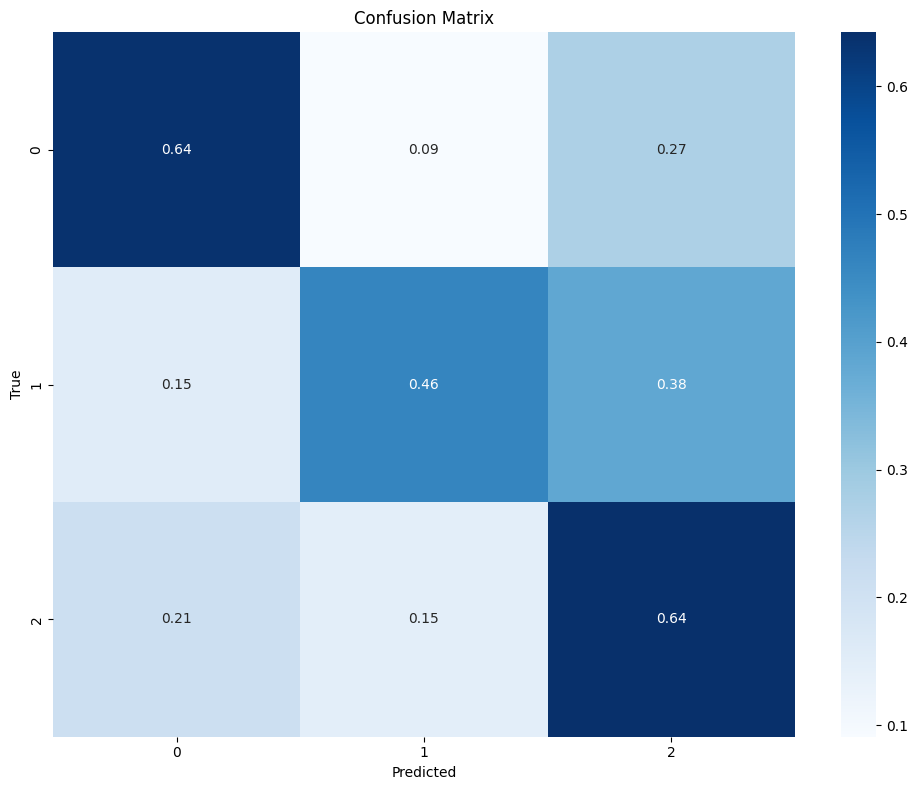

In [304]:
# Load the best model from MLflow
best_model = mlflow.sklearn.load_model(f"runs:/{best_run.run_id}/model")

# Make predictions on the test set
test_predictions = best_model.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, test_predictions)
test_balanced_accuracy = balanced_accuracy_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions, average="weighted")

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Balanced Accuracy: {test_balanced_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Generate classification report
print("\nClassification Report:")
print(
    classification_report(y_test, test_predictions, target_names=label_encoder.classes_)
)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, test_predictions, normalize="true")

# Plot confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test),
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()